# HVAC vs Temperature
Steve Smith
Dec 2024
* The goal of this is to predict HVAC usage for a given outdoor temp. 
* This could help determine how much more money is spent for a given temp difference or if there are inefficiences in HVAC. 

There are two sources for this data to combine: 
1. Historical outdoor temperatures for the past year
2. Historical heating and cooling system usage provided by NEST
Need to add a document on how this was obtainied

## Load modules and data

In [1]:
import pandas as pd
from plotnine import ggplot,aes,geom_point,geom_line,geom_abline,ylab,xlab
from sklearn.linear_model import LinearRegression
import numpy as np


In [2]:
date_format="%Y-%m-%d"
DATA_DIR="~/Documents/"
WEATHER_DATA= f"{DATA_DIR}weather.tsv" 
HVAC_USAGE= f"{DATA_DIR}energy_use.tsv" 

# Data from National Weather 
weather=pd.read_csv(WEATHER_DATA,sep="\t")
weather_long=pd.melt(weather,id_vars=["Unnamed: 0","STATION","DATE"])
# convert to date format
weather_long['DATE']=pd.to_datetime(weather_long['DATE'],format=date_format)
display(weather_long)

# Data from NEST
#TODO: replace with new json data! 
energy_use=pd.read_csv(HVAC_USAGE,sep="\t")
energy_use['use_mins']=energy_use['data']/60
energy_use['asDATE']=pd.to_datetime(energy_use['start'],format="ISO8601")
energy_use['DATE']=pd.to_datetime(energy_use['asDATE']).dt.strftime(date_format)
energy_use['asDATE']=pd.to_datetime(energy_use['asDATE'],format=date_format)

display(energy_use)

# HVAC state map, split out factors into their own variables
hvac_state_map = pd.read_csv("/Users/stevensmith/Projects/Random_Projects/hvac_usage/hvac_type_map.tsv",sep="\t")


,Unnamed: 0,STATION,DATE,variable,value
0,41494,USW00013739,2023-01-01,TAVG,51.0
1,41495,USW00013739,2023-01-02,TAVG,46.0
2,41496,USW00013739,2023-01-03,TAVG,52.0
3,41497,USW00013739,2023-01-04,TAVG,59.0
4,41498,USW00013739,2023-01-05,TAVG,58.0
...,...,...,...,...,...
1707,41917,USW00013739,2024-02-28,TOBS,NaN
1708,41918,USW00013739,2024-02-29,TOBS,NaN
1709,41919,USW00013739,2024-03-01,TOBS,NaN
1710,41920,USW00013739,2024-03-02,TOBS,NaN


,Unnamed: 0,start,stop,type,data,use_mins,asDATE,DATE
0,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2023-04-09 04:00:00+00:00,2023-04-09
1,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,21360,356.0,2023-04-09 04:00:00+00:00,2023-04-09
2,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,29400,490.0,2023-04-09 04:00:00+00:00,2023-04-09
3,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,180,3.0,2023-04-10 04:00:00+00:00,2023-04-10
4,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,19500,325.0,2023-04-10 04:00:00+00:00,2023-04-10
...,...,...,...,...,...,...,...,...
958,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,8430,140.5,2024-03-04 05:00:00+00:00,2024-03-04
959,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,22980,383.0,2024-03-04 05:00:00+00:00,2024-03-04
960,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2024-03-05 05:00:00+00:00,2024-03-05
961,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,14340,239.0,2024-03-05 05:00:00+00:00,2024-03-05


In [7]:
energy_use['date2'] = pd.to_datetime(energy_use['start']).dt.date
energy_use

,Unnamed: 0,start,stop,type,data,use_mins,date2
0,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2023-04-09
1,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,21360,356.0,2023-04-09
2,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,29400,490.0,2023-04-09
3,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,180,3.0,2023-04-10
4,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,19500,325.0,2023-04-10
...,...,...,...,...,...,...,...
958,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,8430,140.5,2024-03-04
959,0,2024-03-04T05:00:00Z,2024-03-05T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,22980,383.0,2024-03-04
960,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2024-03-05
961,0,2024-03-05T05:00:00Z,2024-03-06T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,14340,239.0,2024-03-05


## Plots
### Outdoor temp vs date
* Weather data includes avg temp, max and min for the weather station in F
* As ecpected the temp is max in summer and min in winter; there are also intra-day fluxuations
* For HVAC data, will use TAVG as the representative temp for the day

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 431 rows containing missing values.
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 428 rows containing missing values.


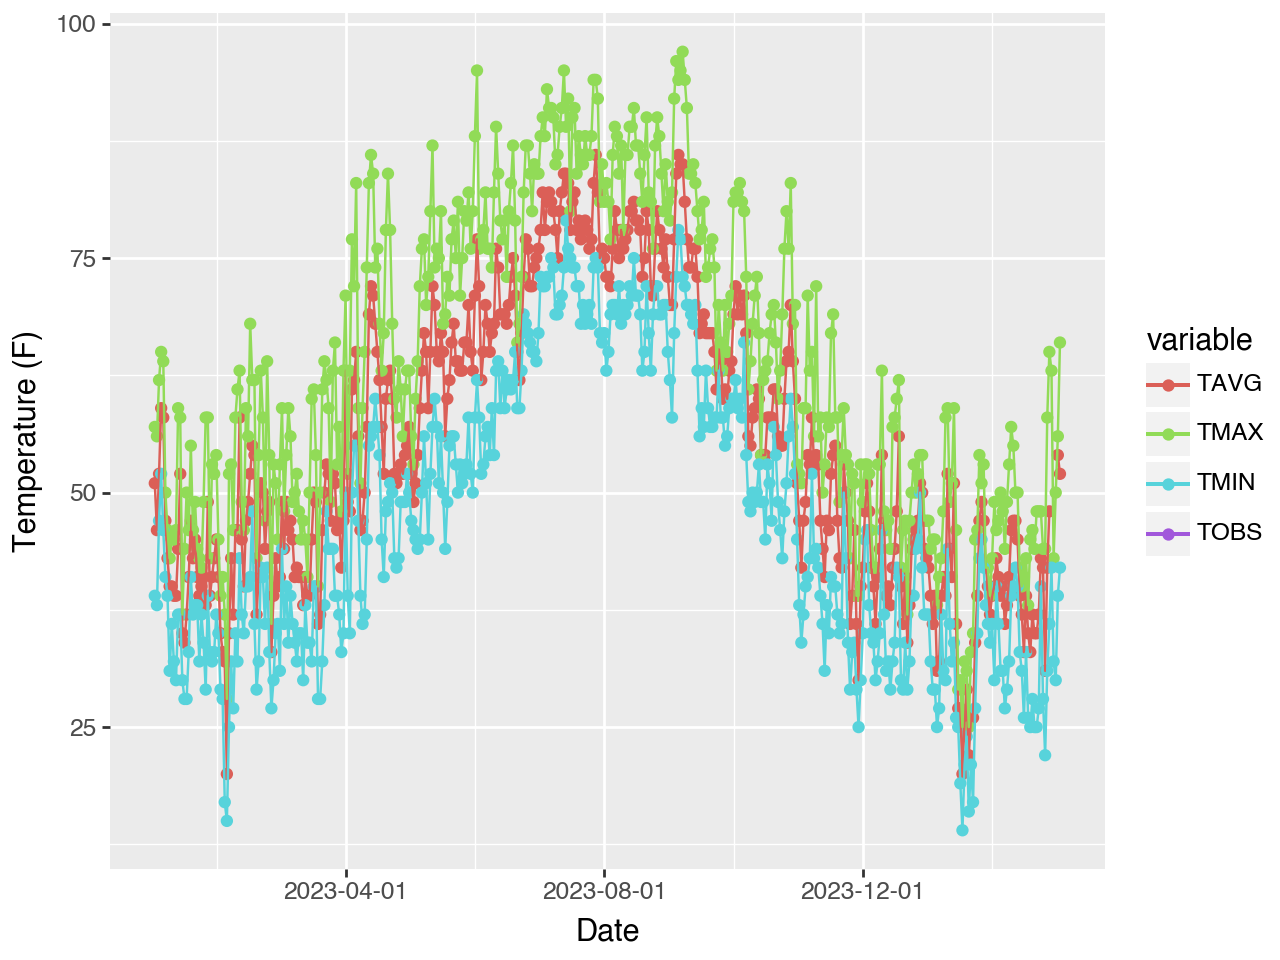

In [23]:

(ggplot(weather_long,aes("DATE","value",color="variable"))+
 geom_point()+
 geom_line()+
 ylab("Temperature (F)")+
 xlab("Date"))


### HVAC usage from year
* Data as reported from NEST for heat, cool and leaf
* General correlation of heating in winter, cooling in summer with other non correlative points
* NEST also has "leaf" which is not all that useful
* My HVAC system has multiple fuel types and modes which are not captured here (just heat or cool)

In [29]:
type(energy_use['DATE'][0])

str

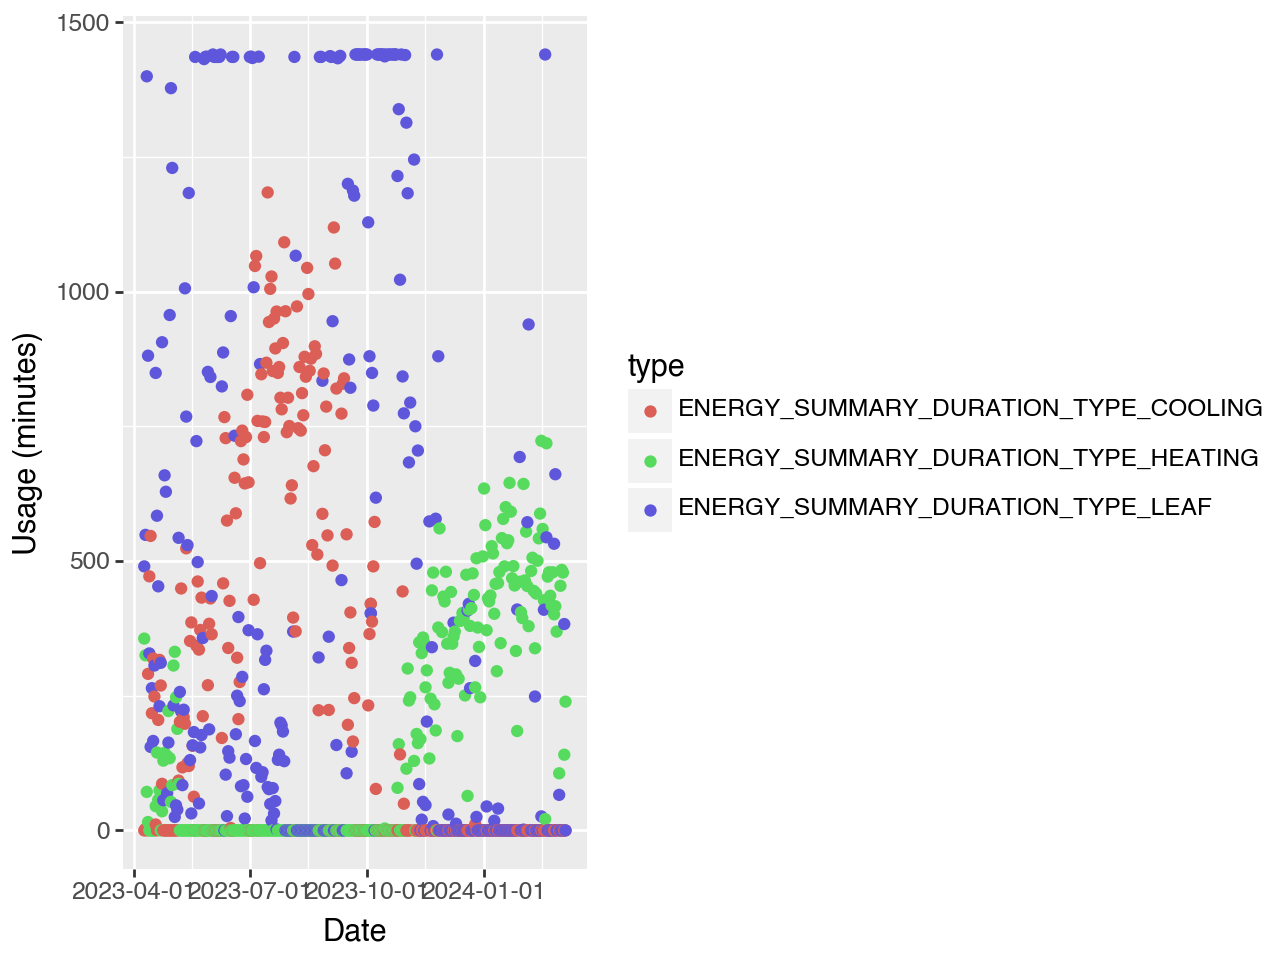

In [30]:
(ggplot(energy_use,aes("asDATE","use_mins",color="type"))+
 geom_point()+
 ylab("Usage (minutes)")+
 xlab("Date"))


### Join HVAC usage and avg daily temp
* Join the HVAC data with the avg daily temp based on date
* HVAC was not used every day

In [31]:
energy_weather=pd.merge(weather,energy_use,on="DATE")
energy_weather


,Unnamed: 0_x,STATION,DATE,TAVG,TMAX,TMIN,TOBS,Unnamed: 0_y,start,stop,type,data,use_mins,asDATE
0,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2023-04-09 04:00:00+00:00
1,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,21360,356.0,2023-04-09 04:00:00+00:00
2,41592,USW00013739,2023-04-09,47.0,59.0,36.0,NaN,0,2023-04-09T04:00:00Z,2023-04-10T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,29400,490.0,2023-04-09 04:00:00+00:00
3,41593,USW00013739,2023-04-10,50.0,65.0,37.0,NaN,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,180,3.0,2023-04-10 04:00:00+00:00
4,41593,USW00013739,2023-04-10,50.0,65.0,37.0,NaN,0,2023-04-10T04:00:00Z,2023-04-11T04:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,19500,325.0,2023-04-10 04:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,41920,USW00013739,2024-03-02,54.0,56.0,39.0,NaN,0,2024-03-02T05:00:00Z,2024-03-03T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,29010,483.5,2024-03-02 05:00:00+00:00
953,41920,USW00013739,2024-03-02,54.0,56.0,39.0,NaN,0,2024-03-02T05:00:00Z,2024-03-03T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_LEAF,0,0.0,2024-03-02 05:00:00+00:00
954,41921,USW00013739,2024-03-03,52.0,66.0,42.0,NaN,0,2024-03-03T05:00:00Z,2024-03-04T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_COOLING,0,0.0,2024-03-03 05:00:00+00:00
955,41921,USW00013739,2024-03-03,52.0,66.0,42.0,NaN,0,2024-03-03T05:00:00Z,2024-03-04T05:00:00Z,ENERGY_SUMMARY_DURATION_TYPE_HEATING,28710,478.5,2024-03-03 05:00:00+00:00


### Linear model of HVAC vs temp


In [61]:

def comptue_lm(df_in):
    usage_model = LinearRegression()
    usage_model.fit(np.array(df_in['TAVG']).reshape(-1, 1), np.array(df_in['use_mins']))
    # Lm fits
    lm_results={'slope':usage_model.coef_[0],'yint':usage_model.intercept_,'fit_model':usage_model}
    print(f"Fitted Usage equation: {lm_results['slope']} x Tavg + {lm_results['yint']}")

    return lm_results

lm_in_cool=energy_weather[(energy_weather['type']=="ENERGY_SUMMARY_DURATION_TYPE_COOLING") & (energy_weather['use_mins']>0)]
lm_in_heat=energy_weather[(~energy_weather['TAVG'].isna()) &(energy_weather['type']=="ENERGY_SUMMARY_DURATION_TYPE_HEATING") & (energy_weather['use_mins']>0)]

lm_res_cool=comptue_lm(lm_in_cool)
lm_res_heat=comptue_lm(lm_in_heat)




Fitted Usage equation: 34.053364170105894 x Tavg + -1895.4648937205343
Fitted Usage equation: -12.303180928162043 x Tavg + 898.1996421696108


/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 6 rows containing missing values.


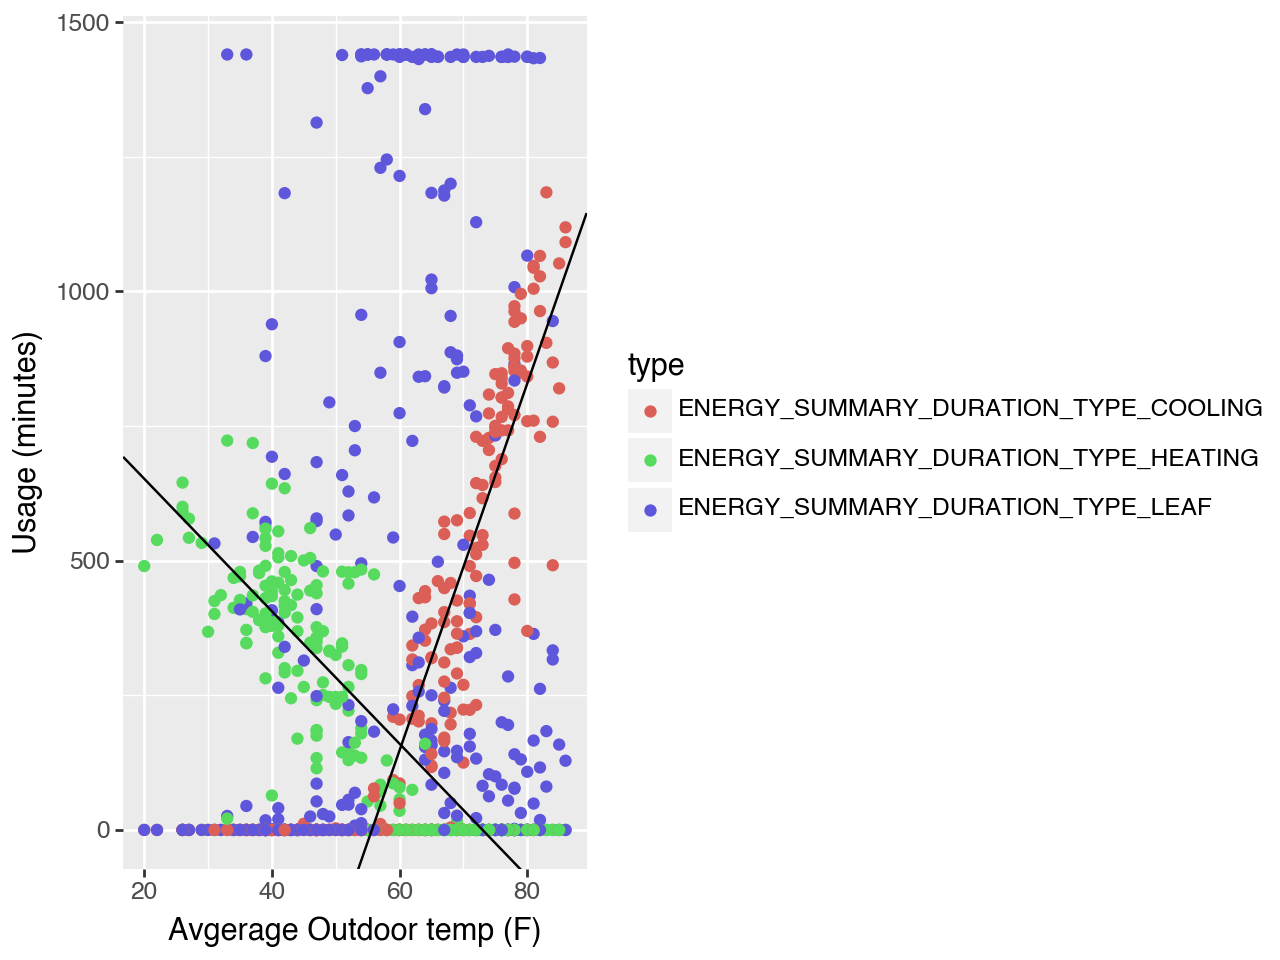

In [59]:
(ggplot(energy_weather,aes("TAVG","use_mins",color="type"))+geom_point()+
  geom_abline(slope=lm_res_cool['slope'],intercept = lm_res_cool['yint'])+
  geom_abline(slope=lm_res_heat['slope'],intercept = lm_res_heat['yint'])+
  ylab("Usage (minutes)")+
  xlab("Avgerage Outdoor temp (F)"))

## Predictions
* From the lm models above, I can predict how much heat or cool usage for a given outside temp


In [72]:

# How many hours does heat run on a 30, 40 & 50 degree day?
display(lm_res_heat['fit_model'].predict(np.array([30,40,50]).reshape(-1,1))/60)

# How many hours does A/C run on a 70,80,90 degree day?
display(lm_res_cool['fit_model'].predict(np.array([70,80,90]).reshape(-1,1))/60)




array([8.81840357, 6.76787342, 4.71734326])

array([ 8.1378433 , 13.813404  , 19.48896469])

# Load NEST json, convert to table

In [508]:
#with open('/Users/stevensmith/Projects/Random_Projects/hvac_usage/HomeHistory.json', 'r') as file:

with open('/Users/stevensmith/Projects/Random_Projects/hvac_usage/HomeHistory_0216205.json', 'r') as file:
    data = json.load(file)


# NEST provides data for all houses on account as an array within 'structure_history'
# index 0 is beach house, 
# index 1 is my house, 
# index 2 is Parent's house
# Look at my house, index 1, for now
#TODO: add a structure of json 
normalized_df=pd.json_normalize(data['structure_history'][1],'events',['structure_name']) 
normalized_df


,timestamp,event.@type,event.event_header.event_importance,event.event_header.subject.resource_id.resource_id,event.event_header.subject.resource_type,event.event_header.subject.structure_id.resource_id,event.event_header.subject.trait_instance_label,event.event_header.subject.pairer_id.resource_id,event.event_header.subject.device.vendor_code,event.event_header.subject.device.product_version,...,event.auth_flow,event.three_lo_api_call.link_owner_history_gaia_id,event.three_lo_api_call.api_name,event.enterprise_name,event.three_lo_api_call.command_name,event.three_lo_api_call.subject.resource_type,event.three_lo_api_call.subject.sdm_id,event.three_lo_api_call.subject.homegraph_id,event.three_lo_api_call.subject.phoenix_id,structure_name
0,2025-02-16T22:42:22.646Z,type.googleapis.com/nestlabs.eventingapi.v1.Ev...,EVENT_IMPORTANCE_PRODUCTION_STANDARD,DEVICE_CCA7C1000045C905,RESOURCE_TYPE_DEVICE,STRUCTURE_018748EF230A35B3,eco_mode_state,STRUCTURE_018748EF230A35B3,9050.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lawnside
1,2025-02-16T20:49:20.872Z,type.googleapis.com/nestlabs.eventingapi.v1.Ev...,EVENT_IMPORTANCE_PRODUCTION_STANDARD,DEVICE_CCA7C1000045C905,RESOURCE_TYPE_DEVICE,STRUCTURE_018748EF230A35B3,eco_mode_state,STRUCTURE_018748EF230A35B3,9050.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lawnside
2,2025-02-16T20:31:25.829Z,type.googleapis.com/nestlabs.eventingapi.v1.Ev...,EVENT_IMPORTANCE_PRODUCTION_STANDARD,DEVICE_CCA7C1000045C905,RESOURCE_TYPE_DEVICE,STRUCTURE_018748EF230A35B3,eco_mode_state,STRUCTURE_018748EF230A35B3,9050.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lawnside
3,2025-02-16T18:01:07.690Z,type.googleapis.com/nestlabs.eventingapi.v1.Ev...,EVENT_IMPORTANCE_PRODUCTION_STANDARD,DEVICE_CCA7C1000045C905,RESOURCE_TYPE_DEVICE,STRUCTURE_018748EF230A35B3,eco_mode_state,STRUCTURE_018748EF230A35B3,9050.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lawnside
4,2025-02-14T11:10:39.887Z,type.googleapis.com/nestlabs.eventingapi.v1.Ev...,EVENT_IMPORTANCE_PRODUCTION_CRITICAL,DEVICE_CCA7C1000045C905,RESOURCE_TYPE_DEVICE,STRUCTURE_018748EF230A35B3,filter_reminder,STRUCTURE_018748EF230A35B3,9050.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lawnside
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33308,2024-05-22T00:57:29.510946Z,type.googleapis.com/home.enterprise.proto.sdm....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,THREE_LEGGED,396868564576,SDM_EXECUTE_DEVICE_COMMAND,Amazon,sdm.devices.commands.SetThermostatTemperatureI...,THERMOSTAT,f8af7f1c-2d93-451c-9138-0de81c4640e1,f8af7f1c-2d93-451c-9138-0de81c4640e1,DEVICE_CCA7C1000045C905,Lawnside
33309,2024-05-21T16:56:30.440659Z,type.googleapis.com/home.enterprise.proto.sdm....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,THREE_LEGGED,396868564576,SDM_EXECUTE_DEVICE_COMMAND,Amazon,sdm.devices.commands.SetThermostatTemperatureI...,THERMOSTAT,f8af7f1c-2d93-451c-9138-0de81c4640e1,f8af7f1c-2d93-451c-9138-0de81c4640e1,DEVICE_CCA7C1000045C905,Lawnside
33310,2024-05-20T10:35:40.762650Z,type.googleapis.com/home.enterprise.proto.sdm....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,THREE_LEGGED,396868564576,SDM_LIST_DEVICES,Amazon,NaN,NaN,NaN,NaN,NaN,Lawnside
33311,2024-05-20T10:00:39.704474Z,type.googleapis.com/home.enterprise.proto.sdm....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,THREE_LEGGED,396868564576,SDM_LIST_DEVICES,Amazon,NaN,NaN,NaN,NaN,NaN,Lawnside


# Load setpoints
Unfortunatley this does not include ALL set points, only head for November? 
Unsure why 

In [519]:
normalized_df.to_csv("~/Documents/foo.csv")

In [524]:

#display(normalized_df['event.event_data.setpoint_type'].drop_duplicates())
display(normalized_df[['event.event_data.cooling_target.value','event.event_data.heating_target.value']].drop_duplicates())
#normalized_df.groupby("event.event_data.setpoint_type").apply('size')

,event.event_data.cooling_target.value,event.event_data.heating_target.value
0,NaN,NaN
37,18.333328,20.195343
38,18.333328,18.333328
39,23.093063,18.333328
40,23.074646,18.333328
41,21.111115,18.333328
42,21.111115,21.553100
43,21.111115,21.511673
44,21.111115,21.111115
45,21.111115,18.040833


# Cut down to HVAC states only
Fitler columns and rows to contain only the HVAC state==True type of data
Convert to long, where the different HVAC states are listed long-wise

In [525]:
val_vars=["event.event_data.hvac_state.alternate_heat_stage_1_active","event.event_data.prior_hvac_state.alternate_heat_stage_2_active","event.event_data.hvac_state.alternate_heat_stage_2_active","event.event_data.prior_hvac_state.heat_stage_1_active","event.event_data.hvac_state.heat_stage_1_active","event.event_data.prior_hvac_state.heat_stage_2_active","event.event_data.hvac_state.heat_stage_2_active","event.event_data.prior_hvac_state.cool_stage_1_active","event.event_data.hvac_state.cool_stage_1_active","event.event_data.prior_hvac_state.cool_stage_2_active","event.event_data.hvac_state.cool_stage_2_active"]
normalized_df_long=pd.melt(normalized_df,
        id_vars=["timestamp","event.event_header.wdm_event_fields.event_id","event.event_header.service_timestamps.salt","event.event_header.subject.trait_instance_label"],
        value_vars=val_vars,var_name="HVAC_state",value_name="activated")

normalized_df_long=normalized_df_long[~normalized_df_long["activated"].isna()]

normalized_df_long

,timestamp,event.event_header.wdm_event_fields.event_id,event.event_header.service_timestamps.salt,event.event_header.subject.trait_instance_label,HVAC_state,activated
272,2025-02-17T00:33:00.437Z,480800,2025-02-17T00:33:00.603Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
274,2025-02-16T23:56:55.304Z,480797,2025-02-16T23:56:55.440Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
285,2025-02-16T16:00:01.213Z,480774,2025-02-16T16:00:01.545Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
287,2025-02-16T15:04:13.330Z,480770,2025-02-16T15:04:13.478Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
289,2025-02-16T14:13:01.658Z,480767,2025-02-16T14:13:01.795Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True
...,...,...,...,...,...,...
346177,2023-04-13T18:57:52.974Z,458889,2023-04-13T20:25:53.105Z,hvac_control,event.event_data.hvac_state.cool_stage_2_active,True
346184,2023-04-13T01:19:53.482Z,458865,2023-04-13T01:19:53.192Z,hvac_control,event.event_data.hvac_state.cool_stage_2_active,True
346197,2023-04-12T21:17:17.442Z,458854,2023-04-13T01:00:57.449Z,hvac_control,event.event_data.hvac_state.cool_stage_2_active,True
346198,2023-04-12T21:17:17.442Z,458854,2023-04-12T21:17:17.391Z,hvac_control,event.event_data.hvac_state.cool_stage_2_active,True


# Format and sort

In [526]:
# Convert timestap
normalized_df_long['timestamp_formatted']=normalized_df_long['timestamp'].str.replace('Z', '+00:00').apply(lambda x: datetime.fromisoformat(x))

# Important to sort by day for next steps
normalized_df_long=normalized_df_long.sort_values(by='timestamp_formatted',ascending=True)
nrow=normalized_df_long.shape[0]

# also important to have the sorted df index 1...nrows
normalized_df_long=normalized_df_long.reset_index(drop=True)
normalized_df_long

,timestamp,event.event_header.wdm_event_fields.event_id,event.event_header.service_timestamps.salt,event.event_header.subject.trait_instance_label,HVAC_state,activated,timestamp_formatted
0,2023-04-08T15:34:10.911Z,262147,2023-04-08T15:34:11.024Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 15:34:10.911000+00:00
1,2023-04-08T15:34:38.939Z,262148,2023-04-08T15:34:39.040Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2023-04-08 15:34:38.939000+00:00
2,2023-04-08T16:47:42.244Z,327686,2023-04-08T16:47:42.307Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 16:47:42.244000+00:00
3,2023-04-08T16:50:44.218Z,327687,2023-04-08T16:50:44.279Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2023-04-08 16:50:44.218000+00:00
4,2023-04-08T16:53:13.858Z,327688,2023-04-08T16:53:13.922Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 16:53:13.858000+00:00
...,...,...,...,...,...,...,...
14804,2025-02-16T23:39:36.737Z,480795,2025-02-16T23:39:36.852Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2025-02-16 23:39:36.737000+00:00
14805,2025-02-16T23:54:43.238Z,480796,2025-02-16T23:54:43.370Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2025-02-16 23:54:43.238000+00:00
14806,2025-02-16T23:56:55.304Z,480797,2025-02-16T23:56:55.440Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2025-02-16 23:56:55.304000+00:00
14807,2025-02-16T23:56:55.304Z,480797,2025-02-16T23:56:55.440Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-02-16 23:56:55.304000+00:00


# Compute length of time at HVAC states
Compute the time detla to the next state. The next state could be the same as previous, but basically, we want the time to the next state (will summarize by state or day later)

In [527]:
# needs to be sorted chronologically and indexed
for index,row in normalized_df_long.iterrows():
    if index >= (nrow-1):
        print("Skipping last row")
    else: 
        next_row=normalized_df_long.loc[index+1,'timestamp_formatted']
        current_row = normalized_df_long.loc[index,'timestamp_formatted']
        delta = next_row - current_row #time detla between states
        normalized_df_long.loc[index,'length'] = delta
normalized_df_long

Skipping last row


,timestamp,event.event_header.wdm_event_fields.event_id,event.event_header.service_timestamps.salt,event.event_header.subject.trait_instance_label,HVAC_state,activated,timestamp_formatted,length
0,2023-04-08T15:34:10.911Z,262147,2023-04-08T15:34:11.024Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 15:34:10.911000+00:00,0 days 00:00:28.028000
1,2023-04-08T15:34:38.939Z,262148,2023-04-08T15:34:39.040Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2023-04-08 15:34:38.939000+00:00,0 days 01:13:03.305000
2,2023-04-08T16:47:42.244Z,327686,2023-04-08T16:47:42.307Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 16:47:42.244000+00:00,0 days 00:03:01.974000
3,2023-04-08T16:50:44.218Z,327687,2023-04-08T16:50:44.279Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2023-04-08 16:50:44.218000+00:00,0 days 00:02:29.640000
4,2023-04-08T16:53:13.858Z,327688,2023-04-08T16:53:13.922Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2023-04-08 16:53:13.858000+00:00,0 days 00:00:00
...,...,...,...,...,...,...,...,...
14804,2025-02-16T23:39:36.737Z,480795,2025-02-16T23:39:36.852Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2025-02-16 23:39:36.737000+00:00,0 days 00:15:06.501000
14805,2025-02-16T23:54:43.238Z,480796,2025-02-16T23:54:43.370Z,hvac_control,event.event_data.hvac_state.heat_stage_1_active,True,2025-02-16 23:54:43.238000+00:00,0 days 00:02:12.066000
14806,2025-02-16T23:56:55.304Z,480797,2025-02-16T23:56:55.440Z,hvac_control,event.event_data.prior_hvac_state.heat_stage_1...,True,2025-02-16 23:56:55.304000+00:00,0 days 00:00:00
14807,2025-02-16T23:56:55.304Z,480797,2025-02-16T23:56:55.440Z,hvac_control,event.event_data.hvac_state.alternate_heat_sta...,True,2025-02-16 23:56:55.304000+00:00,0 days 00:36:05.133000


# Cnvert to date (without time)
To merge with weather data (avg daily temp) and other things, strip off the time
* also add month and year for computing cost per month (and day)
* this needs work due to the timedelta part

In [528]:
normalized_df_long['DATE']=pd.to_datetime(normalized_df_long['timestamp_formatted']).dt.strftime(date_format)
normalized_df_long['DATE']

#normalized_df_long['DATE']=normalized_df_long["timestamp_formatted"].dt.strftime('%Y-%m-%d')
#normalized_df_long["month_year"]=normalized_df_long["timestamp_formatted"].dt.strftime('%Y-%m')

0        2023-04-08
1        2023-04-08
2        2023-04-08
3        2023-04-08
4        2023-04-08
            ...    
14804    2025-02-16
14805    2025-02-16
14806    2025-02-16
14807    2025-02-16
14808    2025-02-17
Name: DATE, Length: 14809, dtype: object

# Summarize time in each state
Notice that there are "prior events". 
TODO: does this affect any calcualtions?

In [529]:
#TODO investuigate the 'prior state'
hvac_state_summary=normalized_df_long[['HVAC_state','length']].groupby('HVAC_state').apply(lambda x: np.sum(x['length'])).reset_index().sort_values(by=0,ascending=False)
hvac_state_summary[~hvac_state_summary['HVAC_state'].str.contains("prior")]



/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_71676/1235656083.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,HVAC_state,0
0,event.event_data.hvac_state.alternate_heat_sta...,105 days 15:51:26.685000
2,event.event_data.hvac_state.cool_stage_1_active,89 days 07:05:24.787000
4,event.event_data.hvac_state.heat_stage_1_active,38 days 16:16:17.883000
3,event.event_data.hvac_state.cool_stage_2_active,9 days 16:01:23.875000
5,event.event_data.hvac_state.heat_stage_2_active,1 days 23:57:03.540000
1,event.event_data.hvac_state.alternate_heat_sta...,1 days 00:26:18.850000


In [530]:
# date ranges
print(np.min(normalized_df_long['DATE']))
print(np.max(normalized_df_long['DATE']))

# 2023-04-08
# 2025-01-08


2023-04-08
2025-02-17


# Join weather data
By DATE
Weather data includes Tavg, min, max and obs?

In [440]:
normalized_df_long['DATE']=pd.to_datetime(normalized_df_long['DATE'],format=date_format)
detail_use_weather=pd.merge(normalized_df_long,weather_long)


# Filter for plots
* Remove 'prior' HVAC state
* Use only avg daily temp

In [441]:
#plot_df=detail_use_weather[(detail_use_weather['variable']=="TAVG") & ~detail_use_weather.HVAC_state.str.contains("prior")]

plot_df=detail_use_weather[ ~detail_use_weather.HVAC_state.str.contains("prior")]


# Summarize total HVAC states by day
There may be multiple times a given state is run on a given day. We need to total each HVAC state across days for the plots to look right - or else it's not proprly summarized
* sum the total HVAC state per day (for each state)

In [442]:
total_time_df=plot_df.groupby(['DATE','HVAC_state','variable']).apply(lambda x: np.sum(x['length'])).reset_index().rename(columns={0:'total_time'})

total_time_tavg_df=pd.merge(plot_df[['DATE','HVAC_state','variable','value']],total_time_df)
total_time_tavg_df.sort_values(by='total_time')

/var/folders/vv/lg2w1mmx79b93kh1fxk_v5p00000gn/T/ipykernel_71676/1298857914.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,DATE,HVAC_state,variable,value,total_time
4396,2023-07-31,event.event_data.hvac_state.cool_stage_2_active,TAVG,76.0,0 days 00:00:00
782,2023-04-25,event.event_data.hvac_state.heat_stage_2_active,TMIN,42.0,0 days 00:00:00
783,2023-04-25,event.event_data.hvac_state.heat_stage_2_active,TOBS,NaN,0 days 00:00:00
2254,2023-06-24,event.event_data.hvac_state.cool_stage_2_active,TMIN,69.0,0 days 00:00:00
2253,2023-06-24,event.event_data.hvac_state.cool_stage_2_active,TMAX,82.0,0 days 00:00:00
...,...,...,...,...,...
13278,2024-01-22,event.event_data.hvac_state.alternate_heat_sta...,TMIN,17.0,1 days 00:23:06.908000
13277,2024-01-22,event.event_data.hvac_state.alternate_heat_sta...,TMAX,35.0,1 days 00:23:06.908000
13276,2024-01-22,event.event_data.hvac_state.alternate_heat_sta...,TAVG,26.0,1 days 00:23:06.908000
13287,2024-01-22,event.event_data.hvac_state.alternate_heat_sta...,TOBS,NaN,1 days 00:23:06.908000


# Merge filtered df with HVAC state map
this splits up HVAAC states by 
* Cooling or heating
* Fuel type
* Stage

In [443]:

total_time_tavg_df = pd.merge(total_time_tavg_df,hvac_state_map)


# Add cost by fuel type
total_cost = hours * (unit / hour) * ($/unit)
where 'unit' and $/unit are different for electric and gas (and technically by stage - can add that later)

gas 
* (46.93-10)/35.509 = 1.0400180235996508
* (91.69-8.62) / 82.666 = 1.004887136186582
* (45.30 - 8.62) / 36.660 = 1.0005455537370431


In [503]:
(46.93-10)/35.509
(91.69-8.62) / 82.666
(45.30 - 8.62) / 36.660

1.035 / (100/1000)
127.08 / 111.857


((0.061183+0.139617) + (0.062417+0.149067) + (0.062434 + 0.149067))/3


0.20792833333333335

In [504]:
# add cost factor
# fuel <> units/hour <> $/unit <> units
# gas <> 5 units/hr <> $0.5/hour <> therm
# electric <> 10 units/hr <> $2/hour <> kwHr

fuel_cost_use = pd.DataFrame({"Fuel_type":["Gas","Electric"],
                              "units_hr":[(100/1000),4],
                              "price_unit":[1.00,0.20792833333333335],
                              "service_charge":[0,0],
                              "units":["therms","kWhr"]})

fuel_cost_use["price_hour"]=fuel_cost_use["units_hr"]*fuel_cost_use["price_unit"]+fuel_cost_use["service_charge"]
fuel_cost_use


,Fuel_type,units_hr,price_unit,service_charge,units,price_hour
0,Gas,0.1,1.000000,0,therms,0.100000
1,Electric,4.0,0.207928,0,kWhr,0.831713


In [505]:
# merge cost to df and compute total cost/hour
total_time_tavg_pph_df=pd.merge(total_time_tavg_df,fuel_cost_use)
total_time_tavg_pph_df['total_time_seconds']=total_time_tavg_pph_df['total_time'].dt.total_seconds()

total_time_tavg_pph_df['total_time_hour']=total_time_tavg_pph_df['total_time_seconds']/(60*60)

total_time_tavg_pph_df['total_cost']=total_time_tavg_pph_df['price_hour']*(total_time_tavg_pph_df['total_time_hour'])
total_time_tavg_pph_df

,DATE,HVAC_state,variable,value,total_time,Unnamed: 0,HVAC_state_simple,HVAV_state,Fuel_type,Stage,units_hr,price_unit,service_charge,units,price_hour,total_time_seconds,total_time_hour,total_cost
0,2023-04-08,event.event_data.hvac_state.heat_stage_1_active,TAVG,46.0,0 days 00:03:58.018000,0,Electric_heat_stage1,Heat,Electric,Stage_1,4.0,0.207928,0,kWhr,0.831713,238.018,0.066116,0.054990
1,2023-04-08,event.event_data.hvac_state.heat_stage_1_active,TAVG,46.0,0 days 00:03:58.018000,0,Electric_heat_stage1,Heat,Electric,Stage_1,4.0,0.207928,0,kWhr,0.831713,238.018,0.066116,0.054990
2,2023-04-08,event.event_data.hvac_state.heat_stage_2_active,TAVG,46.0,0 days 00:04:03.175000,1,Electric_heat_stage2,Heat,Electric,Stage_2,4.0,0.207928,0,kWhr,0.831713,243.175,0.067549,0.056181
3,2023-04-08,event.event_data.hvac_state.heat_stage_1_active,TAVG,46.0,0 days 00:03:58.018000,0,Electric_heat_stage1,Heat,Electric,Stage_1,4.0,0.207928,0,kWhr,0.831713,238.018,0.066116,0.054990
4,2023-04-08,event.event_data.hvac_state.alternate_heat_sta...,TAVG,46.0,0 days 00:04:26.359000,2,Gas_heat_stage1,Heat,Gas,Stage_1,0.1,1.000000,0,therms,0.100000,266.359,0.073989,0.007399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4066,2024-03-03,event.event_data.hvac_state.heat_stage_1_active,TAVG,52.0,0 days 03:41:59.022000,0,Electric_heat_stage1,Heat,Electric,Stage_1,4.0,0.207928,0,kWhr,0.831713,13319.022,3.699728,3.077113
4067,2024-03-03,event.event_data.hvac_state.heat_stage_1_active,TAVG,52.0,0 days 03:41:59.022000,0,Electric_heat_stage1,Heat,Electric,Stage_1,4.0,0.207928,0,kWhr,0.831713,13319.022,3.699728,3.077113
4068,2024-03-03,event.event_data.hvac_state.heat_stage_1_active,TAVG,52.0,0 days 03:41:59.022000,0,Electric_heat_stage1,Heat,Electric,Stage_1,4.0,0.207928,0,kWhr,0.831713,13319.022,3.699728,3.077113
4069,2024-03-03,event.event_data.hvac_state.heat_stage_1_active,TAVG,52.0,0 days 03:41:59.022000,0,Electric_heat_stage1,Heat,Electric,Stage_1,4.0,0.207928,0,kWhr,0.831713,13319.022,3.699728,3.077113


# Plots
## Daily Temp vs HVAC state running time

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


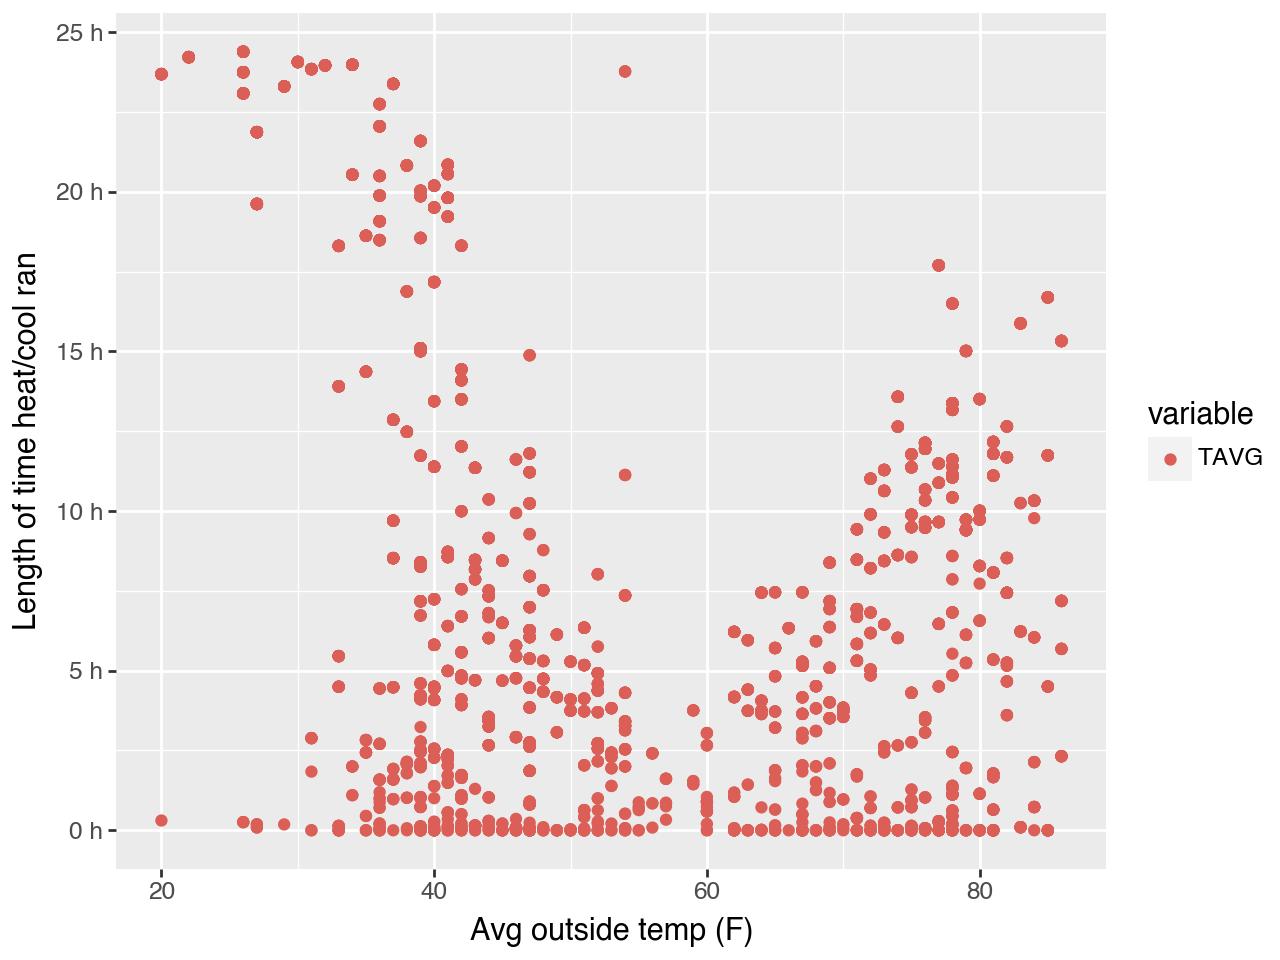

In [493]:
from plotnine import element_text,theme
(ggplot(total_time_tavg_df,aes("value","total_time",color="variable")) + 
 geom_point()+
  ylab("Length of time heat/cool ran")+
 xlab("Avg outside temp (F)")
        )



/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


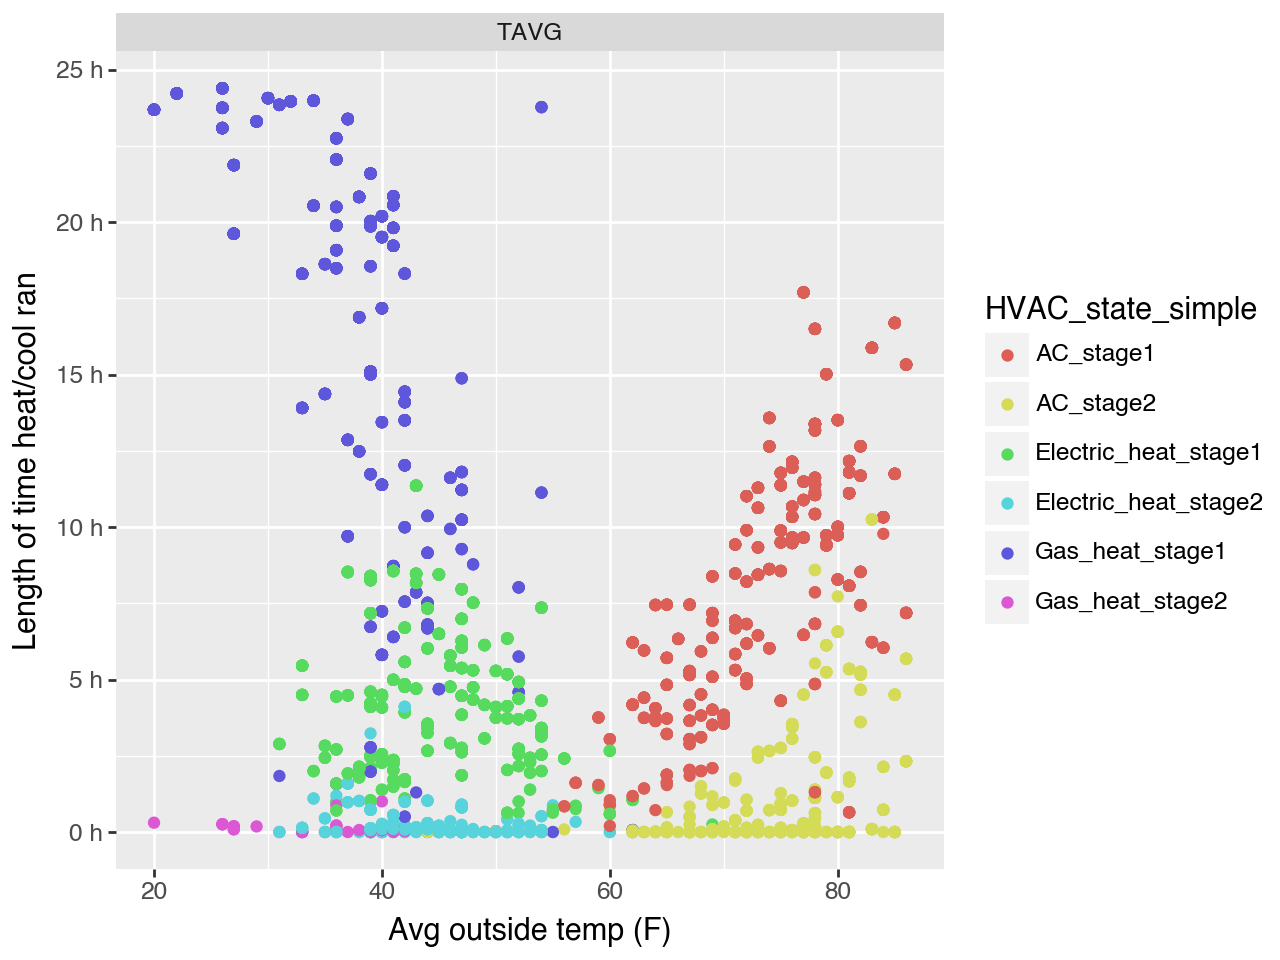

In [494]:
(ggplot(total_time_tavg_df,aes("value","total_time",color="HVAC_state_simple")) + 
 geom_point()+
  ylab("Length of time heat/cool ran")+
 xlab("Avg outside temp (F)")+
 facet_wrap("~variable")
        )

# Tmax and Tmin shifted by roughly the same amount. Tavg seems to capture the trends just fine, so use only this measurement from now on

### Split by heat/cool and shape by stage

In [506]:
# only include TAVG
total_time_tavg_df=total_time_tavg_df[total_time_tavg_df['variable']=="TAVG"]

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


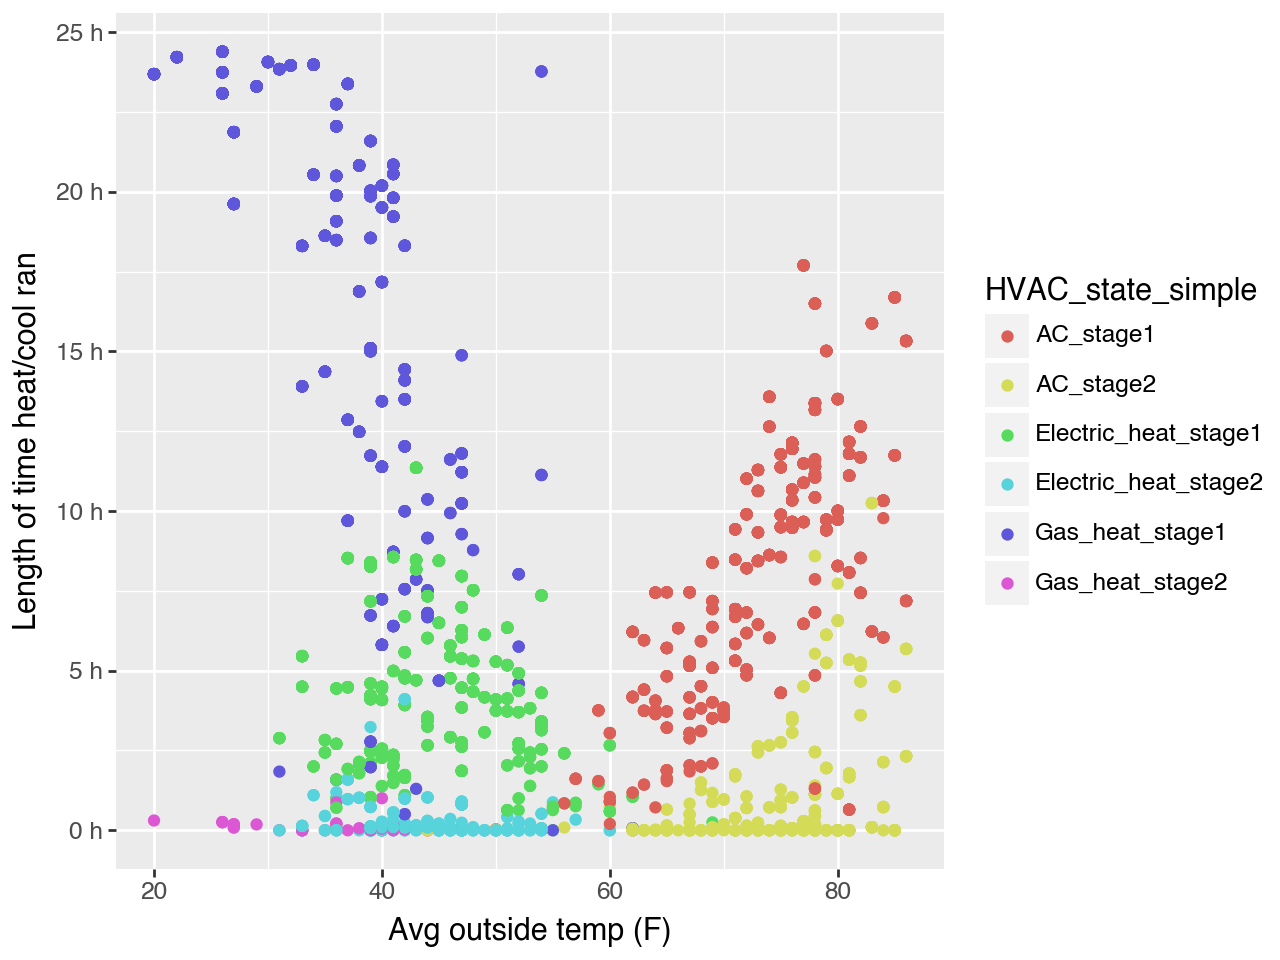

In [469]:
(ggplot(total_time_tavg_df,aes("value","total_time",color="HVAC_state_simple")) + 
 geom_point()+
  ylab("Length of time heat/cool ran")+
 xlab("Avg outside temp (F)")
        )


/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


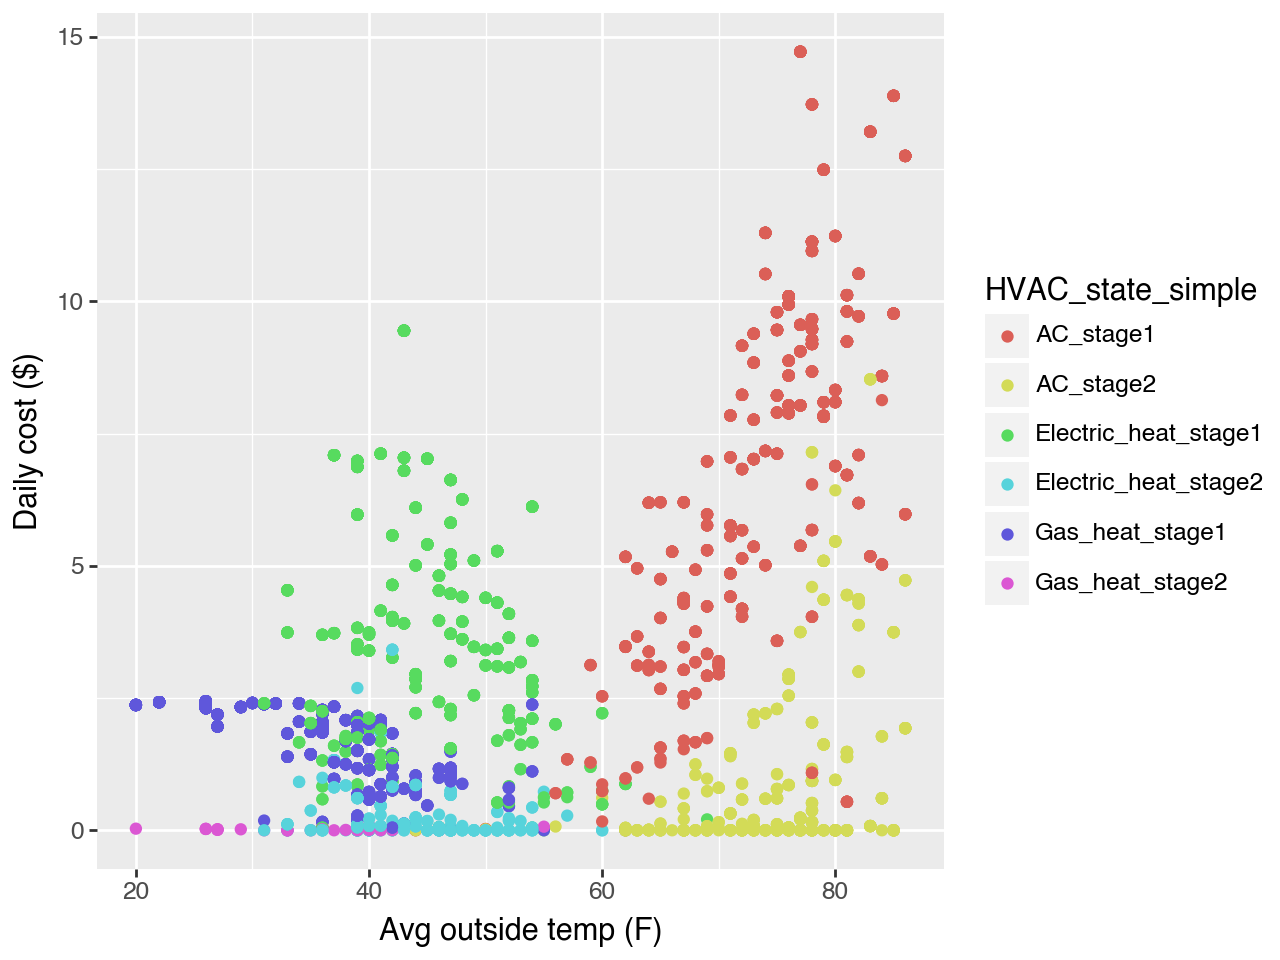

In [507]:
# hours converted to cost
(ggplot(total_time_tavg_pph_df,aes("value","total_cost",color="HVAC_state_simple")) + 
 geom_point()+
  ylab("Daily cost ($)")+
 xlab("Avg outside temp (F)")
        )


/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


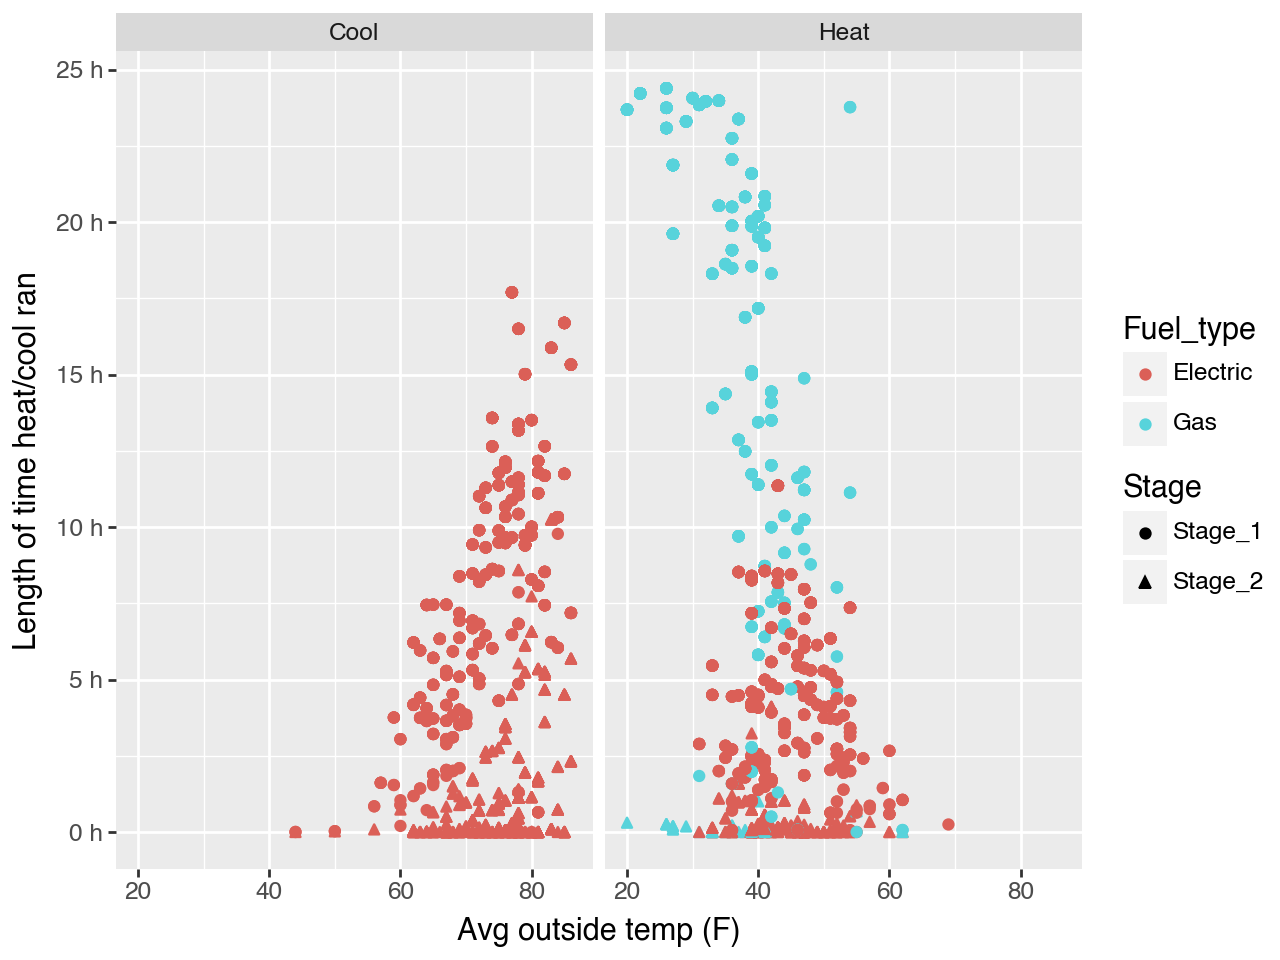

In [334]:
(ggplot(total_time_tavg_df,aes("value","total_time",color="Fuel_type",shape="Stage")) + 
 geom_point()+
  ylab("Length of time heat/cool ran")+
 xlab("Avg outside temp (F)")+
 facet_wrap("~HVAV_state")
        )


/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


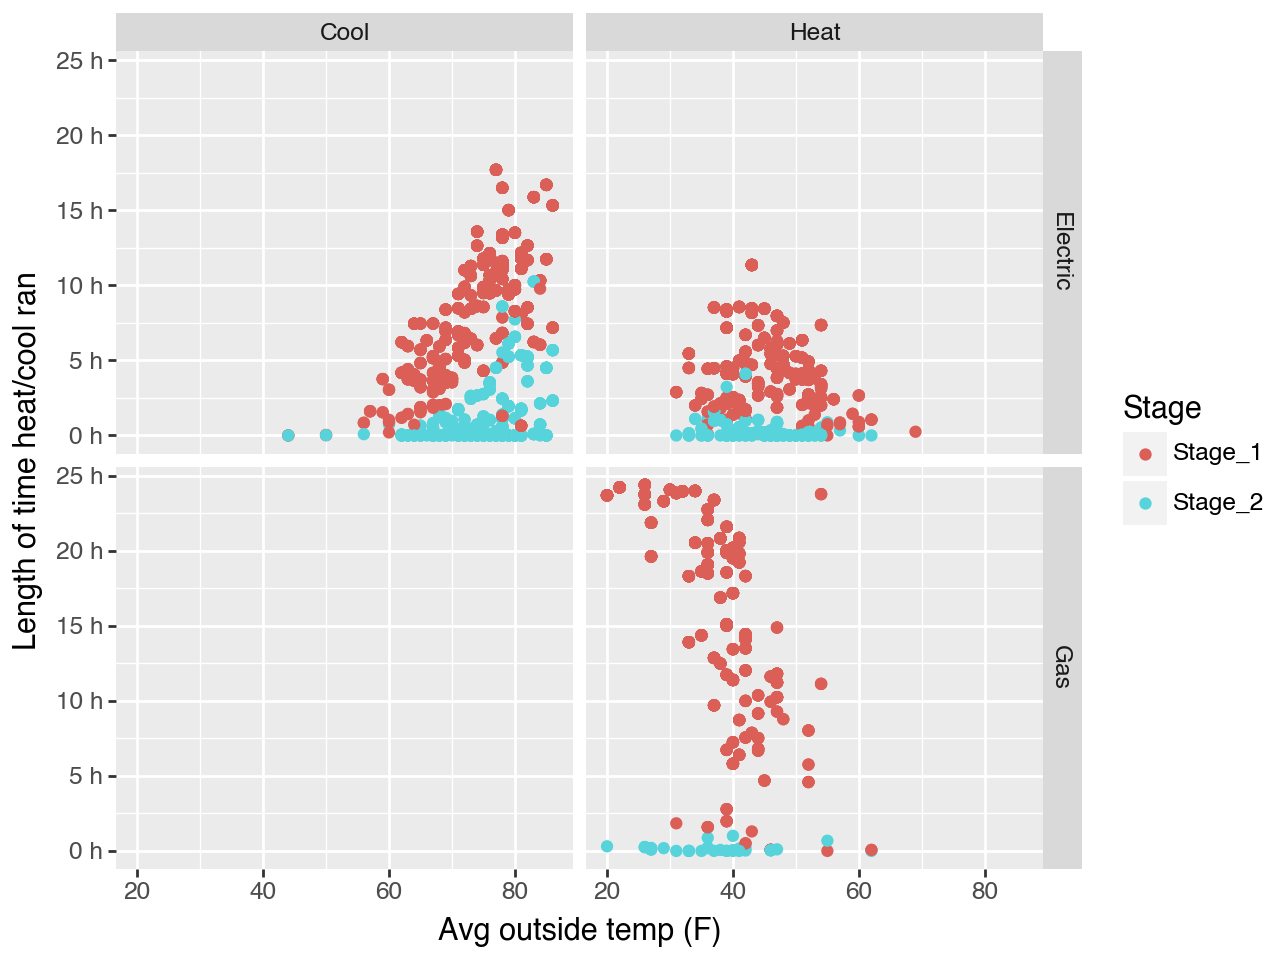

In [335]:
(ggplot(total_time_tavg_df,aes("value","total_time",color="Stage")) + 
 geom_point()+
  ylab("Length of time heat/cool ran")+
 xlab("Avg outside temp (F)")+
 facet_grid("Fuel_type~HVAV_state")
        )
#TODO: fit moel to stage 1 heat, cool, gas, electric 

		

In [372]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# only stage 1
lm_in=total_time_tavg_df[total_time_tavg_df.Stage=="Stage_1"]
x_var = "value"
y_var = "total_time"
fuel_electric = lm_in['Fuel_type']=="Electric"
fuel_gas= lm_in['Fuel_type']=="Gas"
HVAC_state_cool= lm_in['HVAV_state']=="Cool"
HVAC_state_heat= lm_in.HVAV_state=="Heat"
e_heat = lm_in[fuel_electric & HVAC_state_heat]
g_heat = lm_in[fuel_gas & HVAC_state_heat]
ac = lm_in[ HVAC_state_cool]

model = LinearRegression() 
model.fit(np.array(ac[x_var]).reshape(-1, 1), np.array(ac[y_var].dt.seconds)) 
[model.coef_/(24*60),model.intercept_/(24*60)]

[array([0.99811095]), -52.100767904871624]

## Date vs temp 
THis is just a sanity check, but also layers the type of HVAC stage (kind of interesting!)

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 41 rows containing missing values.


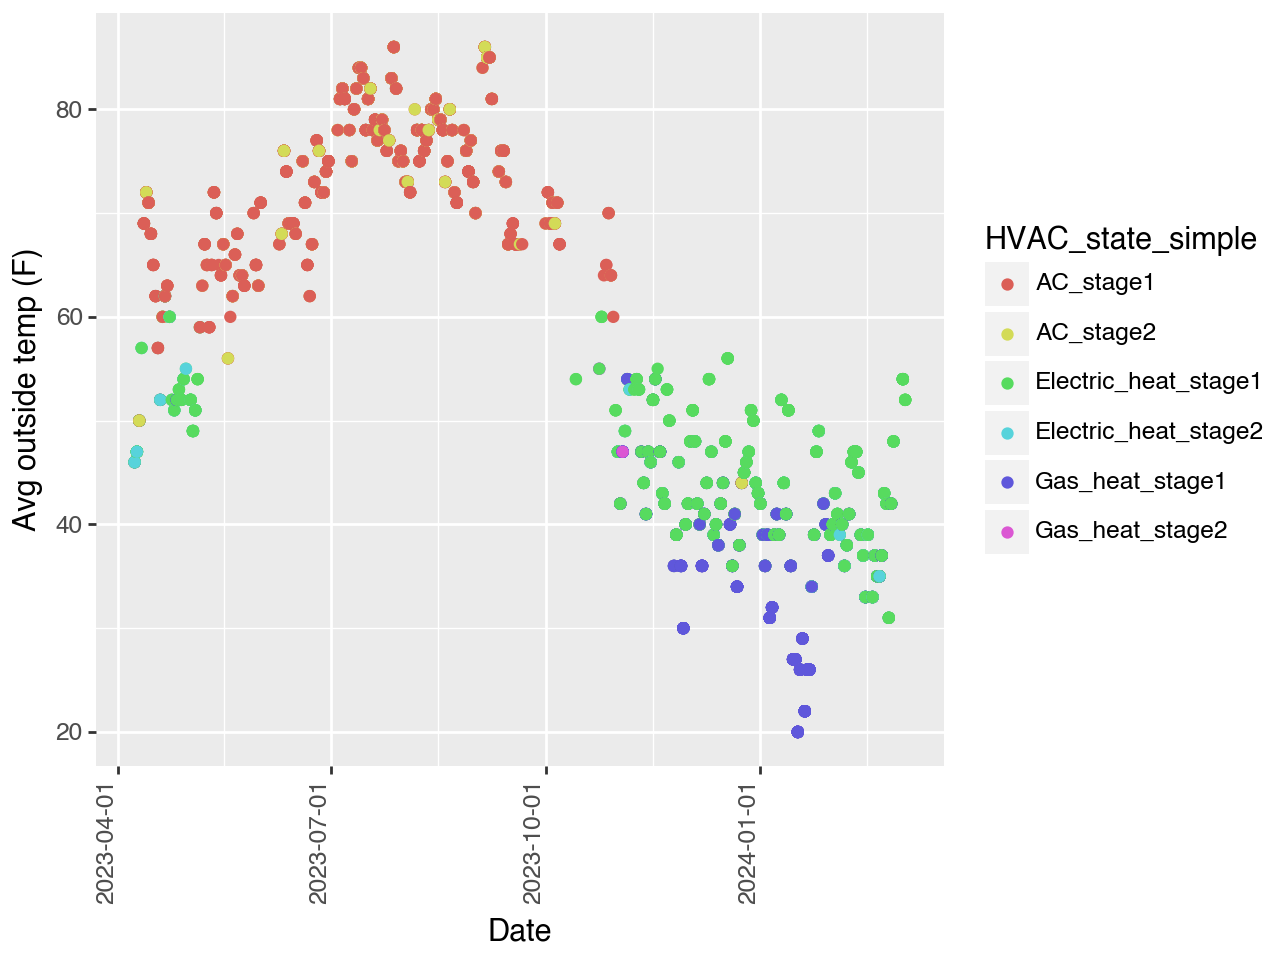

In [336]:
(ggplot(total_time_tavg_df,aes("DATE","value",color="HVAC_state_simple")) + 
 geom_point()+
 ylab("Avg outside temp (F)")+
 xlab("Date")+
 theme(axis_text_x=element_text(rotation=90, hjust=1))
        )

# there are clear delinations vs time of year when switching from AC to heat () and from gas/electic

## Histograms of HVAC states
TODO: use the simple HVAC state names (new df)

/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projec

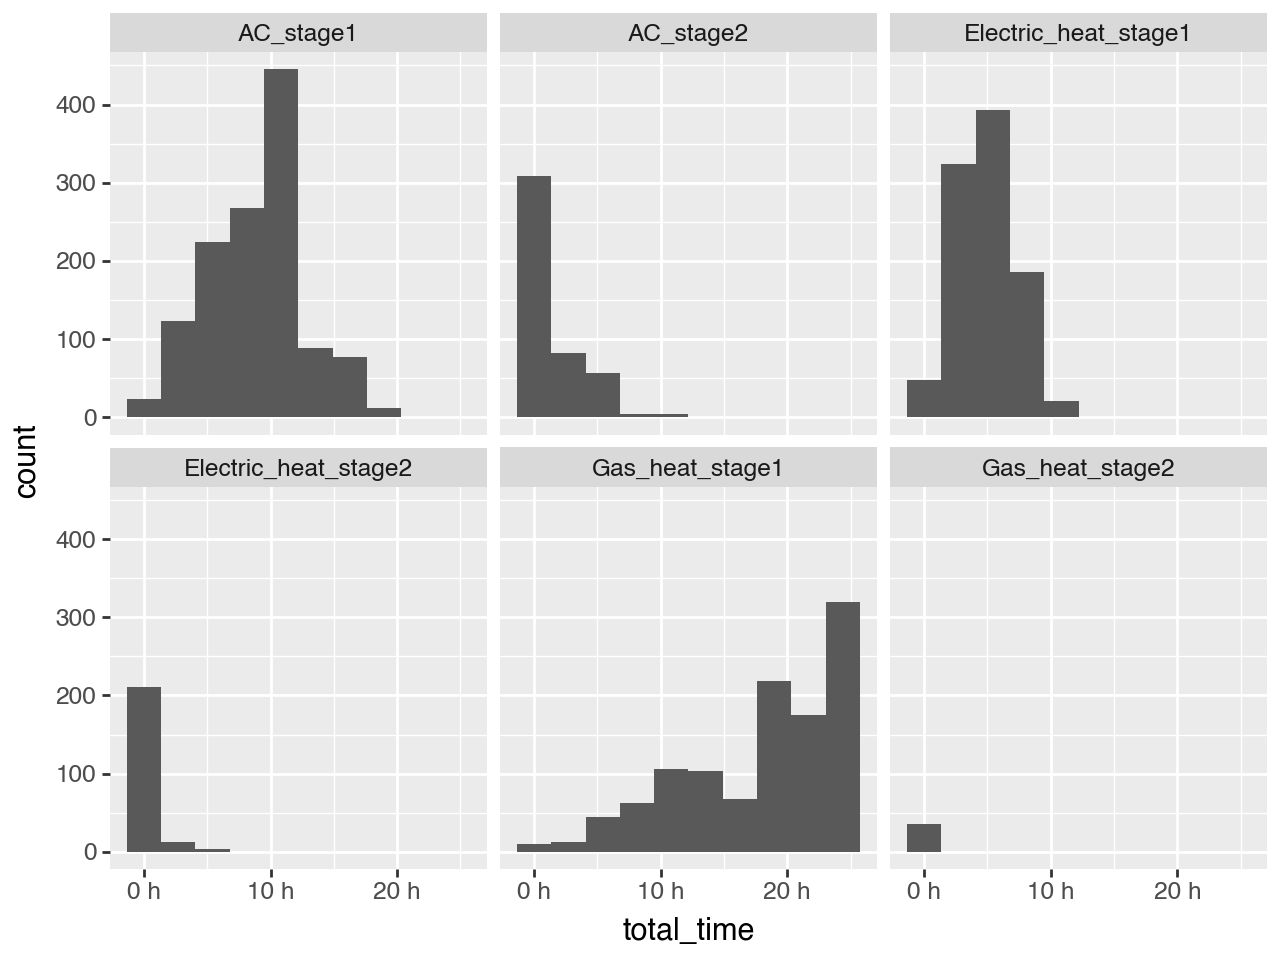

In [337]:
from plotnine import geom_histogram,facet_wrap
(ggplot(total_time_tavg_df,aes("total_time")) + 
 geom_histogram(bins=10)+
 facet_wrap("~HVAC_state_simple")
        )



/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals
/Users/stevensmith/Projects/python_virtual_envs/githubmatcher/lib/python3.9/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_stack requires non-overlapping x intervals


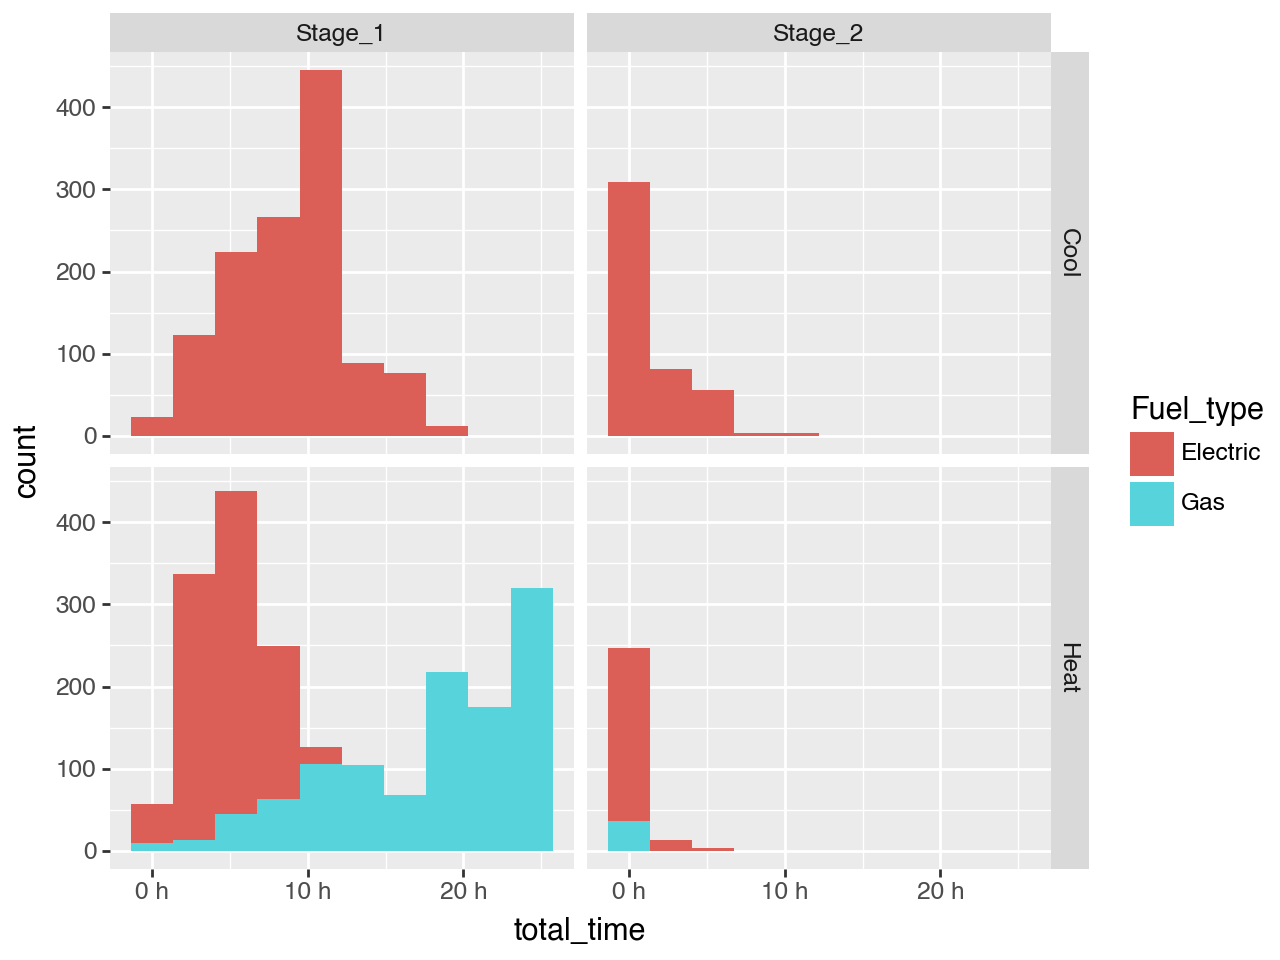

In [338]:

from plotnine import facet_grid
(ggplot(total_time_tavg_df,aes("total_time",fill="Fuel_type")) + 
 geom_histogram(bins=10)+
 facet_grid("HVAV_state~Stage")
        )


# Takeaways & Future
* Cooling usage is more than double that of heating usage for a given temp difference (12 mins/degree vs 34 mins/degree for cooling)
* Is there more granular temp data (hourly)?
* Is there a way to add the set point of the thermostat-> this way could ask the question what changing the thermostat has (THERE MAY BE but current json only has like a month)
* Add in pricing info to translate usage into cost
* Add automatically downloading NEST and/or weather data
* Add README on how to obtain NEST and weather data  
* Clean up plots
* Find the optimal outdoor temp at which to switch the electric to gas heat given running time + cost


* Cooling stage 1 and electric heating stage 1 were run the most from 4/8/23 to 1/8/25 (230 days, 158 days).
* Gas heat was run 72 days while electric head was run 39 days
* The TMax, min and avg daily temps shift the usage plots but by roughly the same value. Tavg seems to capture the trend well enough. 


* There is a trend with stage 1 heating (both electric and gas) and stage 1 cooling
* Stage 2 heating and cooling does not follow the same trend as stage 1, and in fact doesn;t have much of a trend at all (not run nearly as oftern, stage 2 run rarely)
* Gas heat extends the electric heat line
* Gas heat tends to kick in ~40F. 
* When using gas heat, tends to run 15-24 h whereas electric only runs about 10h. 
* Cooling runs about 17 h when temp is 100, <5h when temp is 60
* How does the running of electric and gas translate to cost? Is there an optimal outdoor temp in which to switch> 
* there are 2 peaks with gas heat (10 hrs or 24 hrs). Also the run the most followed by AC stage 1. Electric heat not run for as long


# Sandbox
